In [2]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as T
import torchvision.datasets as D
import torch.nn.functional as F
import numpy as np
import pickle
from matplotlib import pyplot as plt
import sys
sys.path.append("..")
from utils.utils import MyDataset, show_image, visualise_output
from networks.autoencoder import FireAutoencoder
import matplotlib
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
import scipy

In [3]:
train_dataset = MyDataset(root='../../data/complete_random/hetero_1/Sub20x20_full_grid.pkl',
                             tform=lambda x: torch.from_numpy(x, dtype=torch.float
))

In [4]:
latent_dims = 256
capacity = latent_dims//2 
input_size = 20
epochs = 100
sigmoid = False
instance = "hetero_1"
lr1 = 1e-3
params = {
    "input_size": input_size,
    "latent_dims": latent_dims,
    "capacity": capacity,
    "epochs": epochs,
    "sigmoid": sigmoid,
    "instance": instance,
    "lr1": lr1,
}
net = FireAutoencoder(params)
net.load_state_dict(torch.load(f'../weights/hetero_1/AE/sub20x20_latent={latent_dims}_capacity={capacity}_{epochs}_sigmoid={sigmoid}_T1=100_T2=100_lr1={lr1}_lr2=0.0001_lr3=0.0001_normalize=False_weight_decay=0.pth', map_location=torch.device('cpu')))

<All keys matched successfully>

In [5]:
full_loader  = torch.utils.data.DataLoader(train_dataset, batch_size=len(train_dataset), shuffle=False)

In [6]:
all_images, all_r = next(iter(full_loader))

In [6]:
embeddings = net.encode(all_images)

In [9]:
max(all_r)

tensor(-317.4000)

In [7]:
with torch.no_grad():
    X, y = embeddings.numpy(), all_r.numpy()

In [8]:
reg = LinearRegression().fit(X, y)

In [9]:
reg.score(X, y)

0.22378708490322952

In [10]:
reg.predict(X)

array([-666.28754, -646.7117 , -602.51544, ..., -684.18506, -654.98975,
       -599.22174], dtype=float32)

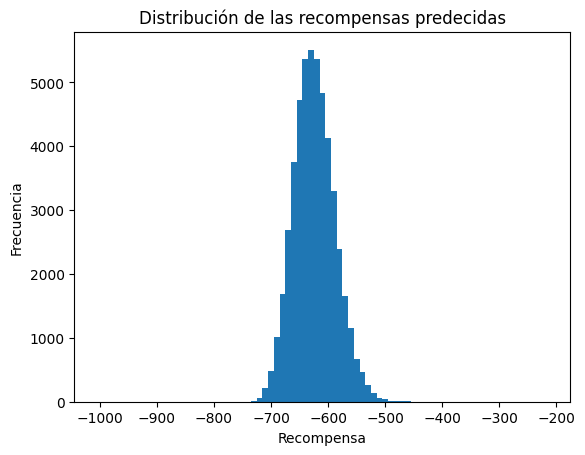

In [13]:
bins = np.arange(-1000, -200, 10)
plt.hist(reg.predict(X), bins=bins, align='left')
plt.title('Distribución de las recompensas predecidas')
plt.xlabel('Recompensa')
plt.ylabel('Frecuencia')
#plt.savefig(f"linear_regresion/reward_classes_distr_{latent_dims}_{epochs}_sigmoid={sigmoid}.png.png")
plt.show()

In [37]:
def linear_func(x):
    return -(np.dot(x,reg.coef_) + reg.intercept_)

In [38]:
reg.intercept_

-628.16046

In [41]:
res = scipy.optimize.minimize(linear_func, x0=np.zeros(latent_dims), method = 'Nelder-Mead')

In [42]:
res

       message: Maximum number of function evaluations has been exceeded.
       success: False
        status: 1
           fun: 346.87801141048294
             x: [ 1.570e-02 -1.016e-01 ... -3.496e-02  1.604e-01]
           nit: 50542
          nfev: 51200
 final_simplex: (array([[ 1.570e-02, -1.016e-01, ..., -3.496e-02,
                         1.604e-01],
                       [ 1.559e-02, -1.012e-01, ..., -3.471e-02,
                         1.604e-01],
                       ...,
                       [ 1.495e-02, -9.779e-02, ..., -3.347e-02,
                         1.545e-01],
                       [ 1.491e-02, -9.778e-02, ..., -3.343e-02,
                         1.545e-01]]), array([ 3.469e+02,  3.473e+02, ...,  3.568e+02,  3.569e+02]))

In [43]:
minimum = torch.from_numpy(res.x)

In [44]:
net.float()

FireAutoencoder(
  (conv1): Conv2d(1, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (conv2): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (fc): Linear(in_features=6400, out_features=256, bias=True)
  (fc_2): Linear(in_features=256, out_features=6400, bias=True)
  (conv1_2): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (conv2_2): ConvTranspose2d(128, 1, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (criterion): MSELoss()
)

In [45]:
solution = net.decode(minimum.float().unsqueeze(0))

In [46]:
if sigmoid:
    solution[solution>=0.5] = 1
    solution[solution<=0.5] = 0
else:
    solution[solution>0] = 1

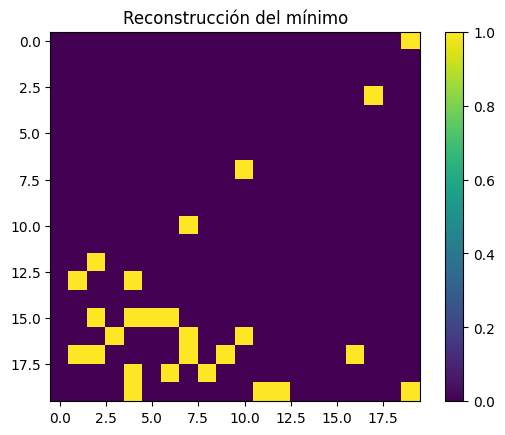

In [47]:
with torch.no_grad():
        plt.title('Reconstrucción del mínimo')
        plt.imshow(solution[0][0].numpy())
        #plt.savefig(f"linear_regresion/v1/minimum_decoding_{latent_dims}_{epochs}_sigmoid={sigmoid}.png")
        plt.colorbar()
        plt.show()

In [49]:
with torch.no_grad():
    print(repr(solution[0][0].numpy()))

array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 1.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 1., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0.